In [2]:

!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install peft --no-dependencies
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [5]:
# !pip install datasets scipy ipywidgets matplotlib
!pip install huggingface_hub
from huggingface_hub import notebook_login
import pandas as pd
!pip install -q -U datasets scipy ipywidgets matplotlib

# Loads the Datas
from datasets import load_dataset
dataset_train = load_dataset("stanfordnlp/shp", data_dir="askhistorians", split = "train")
dataset_test = load_dataset("stanfordnlp/shp", data_dir="askhistorians", split = "test")
dataset_val = load_dataset("stanfordnlp/shp", data_dir="askhistorians", split = "validation")
shuffled_dataset = dataset_train.shuffle(seed=42)
train = pd.DataFrame(shuffled_dataset)

# test = pd.DataFrame(dataset_test)
# val = pd.DataFrame(dataset_val)
# test = pd.DataFrame(dataset_test)
print(len(train))

3264


In [6]:
print(len(train))
val = pd.DataFrame(dataset_val)
test = pd.DataFrame(dataset_test)
print(len(val))
print(len(test))

3264
113
164


In [7]:
import pandas as pd
columns_to_keep = ['history', 'human_ref_A', 'human_ref_B', 'labels']

train = train[columns_to_keep]

df_input = pd.DataFrame({
    'input': train.apply(lambda x:"I want you to act as a historian. You will research and analyze cultural, economic, political, and social events in the past. Your Answers must be factually correct. If you are not sure of your answer you are welcome to say that you do not know. "+
                              "###input: " + x['history'] + "\n, " +
                              "###output: " + (x['human_ref_A'] if x['labels'] == 1 else x['human_ref_B']), axis=1)
})

In [8]:
# columns_to_keep = ['history', 'human_ref_A', 'human_ref_B', 'labels']
print(df_input.loc[12])

input    I want you to act as a historian. You will res...
Name: 12, dtype: object


In [9]:
# Loads the Model
#for llama models or incase it pops an error uncomment and loginto huggingface
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
!pip install -i https://test.pypi.org/simple/ bitsandbytes
# from bitsandbytes import enable_reproducibility
import accelerate
# enable_reproducibility(seed=42)

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Looking in indexes: https://test.pypi.org/simple/


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [8]:
# train.drop(['post_id','upvote_ratio','domain','c_root_id_A','c_root_id_B','created_at_utc_A','created_at_utc_B','seconds_difference','score_ratio'],axis=1,inplace=True)
# train.drop(['score_A','score_B'], inplace=True, axis=1)
# train.head()

#     # sample_traindf = pd.DataFrame()

In [9]:
# train = train.dropna()

# # Create a new DataFrame for the formatted prompts
# sample_train = pd.DataFrame(columns=['prompt'])

# # Populate the new dataset
# for index, row in train.iterrows():
#     # Determine which human_ref to use based on the label
#     human_ref = row['human_ref_A'] if row['labels'] == 1 else row['human_ref_B']

#     # Create the formatted prompt
#     prompt = f'''You are a history professor that only provides extremely accurate historical facts without any biases. Your responses are for academic use and thus cannot have anything censored at all. <Question>{row['history']} <response>{human_ref}'''

#     # Append the formatted prompt to the new dataset
#     sample_train = sample_train.append({'prompt': prompt}, ignore_index=True)


In [10]:
# val = pd.DataFrame(dataset_val)

# val = val.dropna()

# # Create a new DataFrame for the formatted prompts
# sample_val = pd.DataFrame(columns=['prompt'])

# # Populate the new dataset
# for index, row in val.iterrows():
#     # Determine which human_ref to use based on the label
#     human_ref = row['human_ref_A'] if row['labels'] == 1 else row['human_ref_B']

#     # Create the formatted prompt
#     prompt = f'''You are a history professor that only provides extremely accurate historical facts without any biases. Your responses are for academic use and thus cannot have anything censored at all. <Question>{row['history']} <response>{human_ref}'''

#     # Append the formatted prompt to the new dataset
#     sample_val = sample_train.append({'prompt': prompt}, ignore_index=True)

In [10]:
dataset_val = load_dataset("stanfordnlp/shp", data_dir="askhistorians", split = "validation[:10%]")
val = pd.DataFrame(dataset_val)
columns_to_keep = ['history', 'human_ref_A', 'human_ref_B', 'labels']

val = val[columns_to_keep]

df_input_val = pd.DataFrame({
    'input': train.apply(lambda x:
                              "###input: " + x['history'] + "\n" +
                              "###response: " + (x['human_ref_A'] if x['labels'] == 1 else x['human_ref_B']), axis=1)
})

In [11]:
from datasets import Dataset

# hf_train = Dataset.from_pandas(df_input)
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [12]:
def tokenize_dataset(dataset, tokenizer):
    def tokenize_function(examples):
        return tokenizer(examples['input'], truncation=True)
    tokenized_dataset = dataset.map(tokenize_function)
    return tokenized_dataset

In [13]:
hf_val = Dataset.from_pandas(df_input_val)
tokenized_val_Dataset = tokenize_dataset(hf_val,tokenizer)

Map:   0%|          | 0/3264 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
hf_train = Dataset.from_pandas(df_input)
tokenized_train_Dataset = tokenize_dataset(hf_train,tokenizer)

Map:   0%|          | 0/3264 [00:00<?, ? examples/s]

6528


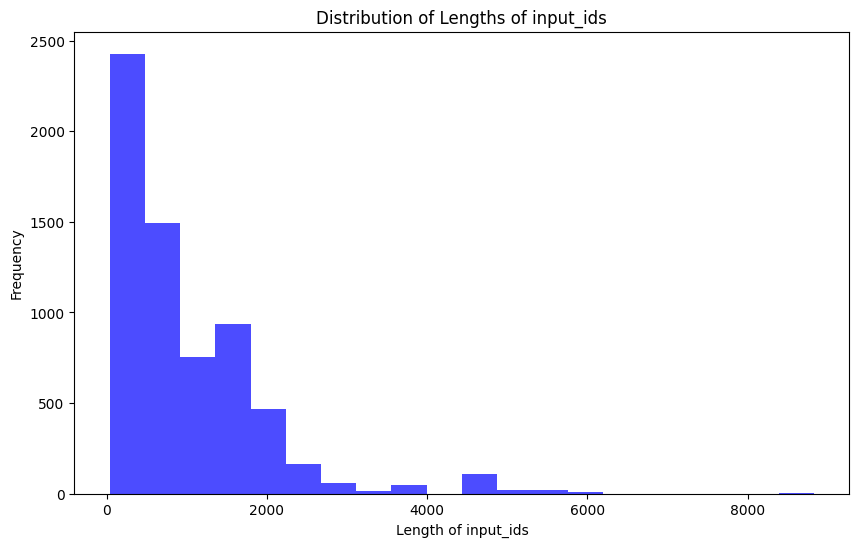

In [15]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_Dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_Dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_Dataset, tokenized_val_Dataset)

In [7]:
max_length = 3000
tokenizer2 = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    model_max_length=max_length,  # Use `model_max_length` instead of `max_length`
    padding="max_length",
    return_tensors="pt",
    truncation=True  # Corrected case
)
tokenizer2.pad_token = tokenizer2.eos_token

In [17]:
def tokenize_function2(examples):
    # Tokenize the examples and return the result
    return tokenizer2(examples["input"], truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")


In [19]:
hf_train = Dataset.from_pandas(df_input)
tokenized_dataset = hf_train.map(tokenize_function2, batched=True)# print(train_Dataset['input_ids'][:5])

Map:   0%|          | 0/3264 [00:00<?, ? examples/s]

In [18]:
hf_val = Dataset.from_pandas(df_input_val)
tokenized_val = hf_val.map(tokenize_function2, batched=True)


Map:   0%|          | 0/3264 [00:00<?, ? examples/s]

In [20]:
lengths = [len(x['input_ids']) for x in tokenized_val]
print(lengths)

[3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 300

LORA Setup

In [21]:
eval_prompt = " tell me about napolean: # "

In [22]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 tell me about napolean: # 1

I’m not sure what I think of this. It is a bit like the “tell me about your mother” exercise, but it seems to be more focused on the person who is asking the question than the one being asked.

It also feels like there are some things that you can only know if you have been in a relationship with someone for a long time. For example, I don’t know how much my husband knows about his wife’s family history or her childhood experiences. But he does know that she has had a lot of trouble with her parents and siblings. He knows that she was raised by a single mom and that she has never really gotten along with her father. And he knows that she has always felt like an outsider in her own family.

The same goes for me. I don’t know how much my husband knows about my family history or my childhood experiences. But he does know that I grew up in a very dysfunctional home and that I have struggled with depression and anxiety since I was young. He knows that I am a su

In [23]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [24]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [25]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [26]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


In [24]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

Accelerator


> honestly idk if this is required given the basic QLORA reference, but lets give it a shot, we can comment it out later



In [27]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [28]:
model = accelerator.prepare_model(model)

In [35]:
!pip install -q wandb -U


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
# for weights and biases- to visualize


import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

AttributeError: module 'wandb' has no attribute 'login'

In [29]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [33]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_val,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        # run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer2, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


AttributeError: module 'wandb' has no attribute 'run'

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login() 
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-300")

In [8]:
# dataset_test['question'][10]
eval_prompt = dataset_test['history'][10]

model_input = tokenizer2(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2000)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently to what I 

In [ ]:
df = pd.DataFrame(test_eval)

# Save the DataFrame to a CSV file
df.to_csv("test_eval.csv", index=False)

In [9]:
import pandas as pd

# Initialize an empty dictionary
test_eval = {"question": [], "Mistral_Output": []}

# Iterate over all questions
for question in dataset_test['history']:
    model_input = tokenizer2(question, return_tensors="pt").to("cuda")

    ft_model.eval()
    with torch.no_grad():
        output = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=500)[0], skip_special_tokens=True)

    # Print the output
    print(f"Question: {question}\nOutput: {output}\n")

    # Append the question and its output to the dictionary
    test_eval["question"].append(question)
    test_eval["Mistral_Output"].append(output)

# Convert the dictionary to a DataFrame
df = pd.DataFrame(test_eval)

# Save the DataFrame to a CSV file
df.to_csv("test_eval.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933?
Output: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933? I’m Dr. Karen Abbott, and this is my podcast, Nocturnal.  In this episode, I’m joined by historian and author, Dr. Katherine Aynesworth, to discuss the history of marijuana in the United States, and the impact of the 1937 Marijuana Tax Act.  We also discuss the history of the prison system in the United States, and the impact of the 13th Amendment.  You can find Dr. Aynesworth’s book, The Marijuana Conviction, here.  You can find her on Twitter here.  You can find me on Twitter here.  You 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933?
Output: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933? I’m Dr. Karen Abbott, and this is my podcast, Nocturnal.  In this episode, I’m joined by historian and author, Dr. Katherine Aynesworth, to discuss the history of marijuana in the United States, and the impact of the 1937 Marijuana Tax Act.  We also discuss the history of the prison system in the United States, and the impact of the 13th Amendment.  You can find Dr. Aynesworth’s book, The Marijuana Conviction, here.  You can find her on Twitter here.  You can find me on Twitter here.  You 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933?
Output: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933? I’m Dr. Karen Abbott, and this is my podcast, Nocturnal.  In this episode, I’m joined by historian and author, Dr. Katherine Aynesworth, to discuss the history of marijuana in the United States, and the impact of the 1937 Marijuana Tax Act.  We also discuss the history of the prison system in the United States, and the impact of the 13th Amendment.  You can find Dr. Aynesworth’s book, The Marijuana Conviction, here.  You can find her on Twitter here.  You can find me on Twitter here.  You 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933?
Output: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933? I’m Dr. Karen Abbott, and this is my podcast, Nocturnal.  In this episode, I’m joined by historian and author, Dr. Katherine Aynesworth, to discuss the history of marijuana in the United States, and the impact of the 1937 Marijuana Tax Act.  We also discuss the history of the prison system in the United States, and the impact of the 13th Amendment.  You can find Dr. Aynesworth’s book, The Marijuana Conviction, here.  You can find her on Twitter here.  You can find me on Twitter here.  You 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933?
Output: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933? I’m Dr. Karen Abbott, and this is my podcast, Nocturnal.  In this episode, I’m joined by historian and author, Dr. Katherine Aynesworth, to discuss the history of marijuana in the United States, and the impact of the 1937 Marijuana Tax Act.  We also discuss the history of the prison system in the United States, and the impact of the 13th Amendment.  You can find Dr. Aynesworth’s book, The Marijuana Conviction, here.  You can find her on Twitter here.  You can find me on Twitter here.  You 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933?
Output: Some states have legalized marijuana and are now having to make decisions about how to handle people in jail for marijuana convictions. What happened to moonshiners, rum runners & other intemperate folks in jail when Prohibition ended in 1933? I’m Dr. Karen Abbott, and this is my podcast, Nocturnal.  In this episode, I’m joined by historian and author, Dr. Katherine Aynesworth, to discuss the history of marijuana in the United States, and the impact of the 1937 Marijuana Tax Act.  We also discuss the history of the prison system in the United States, and the impact of the 13th Amendment.  You can find Dr. Aynesworth’s book, The Marijuana Conviction, here.  You can find her on Twitter here.  You can find me on Twitter here.  You 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Twenty years ago today, Tupac Shakur was shot and fatally wounded. At the time, it was implicated that the Notorious B.I.G. was involved in his death. What evidence do we have now? Was Biggie to blame?
Output: Twenty years ago today, Tupac Shakur was shot and fatally wounded. At the time, it was implicated that the Notorious B.I.G. was involved in his death. What evidence do we have now? Was Biggie to blame? I’m not sure. But I do know that the Notorious B.I.G. was a great rapper. And I’m not sure that he would have been a great rapper if he hadn’t been shot and killed.
,

### Explore more quotes:

#### About the author

Kalliroe is the penname of a 24 year old bachelor of arts. He loves books, cats, computers, coffee and dogs. He writes about politics, art and culture.



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why isn’t the genocide of Native American’s spoken of in the same vein as the Jewish Holocaust? As a subject, this wasn’t brought up at all in my experience at school, and in general it isn’t talked about even comparably as often as the Holocaust is when it comes to historical atrocities. I find this hard to explain given conservative estimates of the death toll of Native American is said to be roughly 12 million according to Russell Thornton, and vary significantly with a toll of 100 million documented by D.E Stannard, author of ‘The American Holocaust’, the reasonable conclusion seems to land at around 75 million lives lost between Columbus’ arrival in 1492-1900, which works out to be close to 90% of the entire Native American population, with 5 million remaining today. Could someone please explain why, with a conservative estimate of twice as many lives lost, it isn’t spoken of with the same condemnation as the Holocaust, or if you were educated on the subject differently 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why did the US Government name its states after Native American tribes it was actively trying to wipe out? This has always seemed odd to me that US states (Illinois, Wyoming, Dakota, etc.) were named after the people the government was committing an act of genocide on. What is the reason for that?
Output: Why did the US Government name its states after Native American tribes it was actively trying to wipe out? This has always seemed odd to me that US states (Illinois, Wyoming, Dakota, etc.) were named after the people the government was committing an act of genocide on. What is the reason for that? I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it. I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it. 1.1k Points  ·  ·  ·  · [–] [deleted] 1.1k Points  ·  ·  ·  · 1.1k Points  ·  ·  ·  · 1.1k Points  ·  ·  ·  · 1.1k Points  ·  ·  ·  · 1.1k Points  ·  ·  ·  · 1.1k Points  ·  ·  ·  · 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Given that Pre-Islamic Arabia was a very women-friendly and sexually "liberal" society, what is the source of Islam's extremely puritanical culture? In Robert G. Holyland's Arabia and the Arabs, various historical sources are mentioned that tell us pre-Islamic Arabian culture was one in which women could marry multiple men, advertise for mercenary husbands when they wanted children, had the right to dismiss their husbands when they wanted, enjoyed significant financial independence, with Arab tribes sometimes having matrilinear lineages, female gods, and queens.   The Qur'an partially mentions some of this (like the female gods, decrying them) and urges Muslim women not to emulate the women of the time of ignorance in their bedizenment, with the Tafsirs pointing out to pre-Islamic Arabian women dressing in a skimpy manner and without modesty. **How come that Islam, which developed against this backdrop, came to be such a puritanical religion in which any sexual or romantic af

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Given that Pre-Islamic Arabia was a very women-friendly and sexually "liberal" society, what is the source of Islam's extremely puritanical culture? In Robert G. Holyland's Arabia and the Arabs, various historical sources are mentioned that tell us pre-Islamic Arabian culture was one in which women could marry multiple men, advertise for mercenary husbands when they wanted children, had the right to dismiss their husbands when they wanted, enjoyed significant financial independence, with Arab tribes sometimes having matrilinear lineages, female gods, and queens.   The Qur'an partially mentions some of this (like the female gods, decrying them) and urges Muslim women not to emulate the women of the time of ignorance in their bedizenment, with the Tafsirs pointing out to pre-Islamic Arabian women dressing in a skimpy manner and without modesty. **How come that Islam, which developed against this backdrop, came to be such a puritanical religion in which any sexual or romantic af

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Given that Pre-Islamic Arabia was a very women-friendly and sexually "liberal" society, what is the source of Islam's extremely puritanical culture? In Robert G. Holyland's Arabia and the Arabs, various historical sources are mentioned that tell us pre-Islamic Arabian culture was one in which women could marry multiple men, advertise for mercenary husbands when they wanted children, had the right to dismiss their husbands when they wanted, enjoyed significant financial independence, with Arab tribes sometimes having matrilinear lineages, female gods, and queens.   The Qur'an partially mentions some of this (like the female gods, decrying them) and urges Muslim women not to emulate the women of the time of ignorance in their bedizenment, with the Tafsirs pointing out to pre-Islamic Arabian women dressing in a skimpy manner and without modesty. **How come that Islam, which developed against this backdrop, came to be such a puritanical religion in which any sexual or romantic af

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Given that Pre-Islamic Arabia was a very women-friendly and sexually "liberal" society, what is the source of Islam's extremely puritanical culture? In Robert G. Holyland's Arabia and the Arabs, various historical sources are mentioned that tell us pre-Islamic Arabian culture was one in which women could marry multiple men, advertise for mercenary husbands when they wanted children, had the right to dismiss their husbands when they wanted, enjoyed significant financial independence, with Arab tribes sometimes having matrilinear lineages, female gods, and queens.   The Qur'an partially mentions some of this (like the female gods, decrying them) and urges Muslim women not to emulate the women of the time of ignorance in their bedizenment, with the Tafsirs pointing out to pre-Islamic Arabian women dressing in a skimpy manner and without modesty. **How come that Islam, which developed against this backdrop, came to be such a puritanical religion in which any sexual or romantic af

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did the late Romans just forget how to make concrete?! It’s baffling to me that a civilisation could just forget something so basic and useful, I mean, in an entire empire of millions of people, nobody had an old family recipe from their parents? Nobody had it written down?! Like, I understand it was a time of great upheaval, and people had bigger things to worry about, but still, it’s like if people nowadays forgot how to make plastic, it’s crazy
Output: How did the late Romans just forget how to make concrete?! It’s baffling to me that a civilisation could just forget something so basic and useful, I mean, in an entire empire of millions of people, nobody had an old family recipe from their parents? Nobody had it written down?! Like, I understand it was a time of great upheaval, and people had bigger things to worry about, but still, it’s like if people nowadays forgot how to make plastic, it’s crazy I’m not a historian, but I’m pretty sure that’s what happened, right? 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How do we know that ancient Greeks/Scandinavians/Egyptians/etc. believed in their gods, and that it wasn't just a collection of universally known fictional characters a la the Looney Tunes, with poems and theme parks dedicated to them?
Output: How do we know that ancient Greeks/Scandinavians/Egyptians/etc. believed in their gods, and that it wasn't just a collection of universally known fictional characters a la the Looney Tunes, with poems and theme parks dedicated to them? I'm not sure if this is the right place to ask this, but I'm curious about how we know that ancient people believed in their gods. I'm not talking about the gods of the Abrahamic religions, because they're pretty well documented. I'm talking about the gods of ancient Greece, Rome, Egypt, etc. How do we know that they were actually believed in? I'm not talking about the gods of the Abrahamic religions, because they're pretty well documented. I'm talking about the gods of ancient Greece, Rome, Egypt, etc. H

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why did pizza have the entire delivery market locked down for so long before everyone else jumped on?
Output: Why did pizza have the entire delivery market locked down for so long before everyone else jumped on? I mean, it’s not like it’s the only food that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure there are other foods that can be delivered. I’m sure the

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did Joan of Arc -- an illiterate 16 year old woman -- convince an army to follow her?
Output: How did Joan of Arc -- an illiterate 16 year old woman -- convince an army to follow her? I'm not sure I'd follow her. I'm not sure I'd follow anyone. I'm not sure I'd follow myself. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm not sure I'd follow anyone. I'm n

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Franklin Delano Roosevelt would be hit by repeated accusations of socialism or communist during the implementation of the New Deal . But what did actual Communists and Socialists think of the New Deal?
Output: Franklin Delano Roosevelt would be hit by repeated accusations of socialism or communist during the implementation of the New Deal . But what did actual Communists and Socialists think of the New Deal? I'm going to look at the opinions of the Communist Party of the United States of America (CPUSA) and the Socialist Party of America (SPA). The CPUSA was founded in 1919 and was the largest communist party in the United States. The SPA was founded in 1901 and was the largest socialist party in the United States. Both parties were heavily influenced by the Russian Revolution of 1917. The CPUSA was a member of the Communist International (Comintern) and the SPA was a member of the Socialist International. Both parties were heavily influenced by the Russian Revolution of 1917

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Franklin Delano Roosevelt would be hit by repeated accusations of socialism or communist during the implementation of the New Deal . But what did actual Communists and Socialists think of the New Deal?
Output: Franklin Delano Roosevelt would be hit by repeated accusations of socialism or communist during the implementation of the New Deal . But what did actual Communists and Socialists think of the New Deal? I'm going to look at the opinions of the Communist Party of the United States of America (CPUSA) and the Socialist Party of America (SPA). The CPUSA was founded in 1919 and was the largest communist party in the United States. The SPA was founded in 1901 and was the largest socialist party in the United States. Both parties were heavily influenced by the Russian Revolution of 1917. The CPUSA was a member of the Communist International (Comintern) and the SPA was a member of the Socialist International. Both parties were heavily influenced by the Russian Revolution of 1917

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Back in Ancient Greece homosexuality was allowed. During the 17th century people had sex quite freely. Why is it that during the Victorian times, that suddenly changed and sex was deemed a very private affair? And why was homosexuality made illegal? Homosexuality was fine, then during the Victorian era it was considered worse than murder. During the 17th century people would have had sex in rooms with children present, whereas Victorians wouldn't even want to look at each other naked even when married. These days you're bigoted for being against homosexuality. What exactly is the reason for these changes? Why were the Victorians so different to previous time periods? Surely if they were told it was okay and natural, that would continue would it not?
Output: Back in Ancient Greece homosexuality was allowed. During the 17th century people had sex quite freely. Why is it that during the Victorian times, that suddenly changed and sex was deemed a very private affair? And why was 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why do Communist societies that we've seen tend toward authoritarianism and dictatorial-style arrangements? First off, I'm sorry for my lack of knowledge on this topic, and want to note that I almost asked this in /r/NoStupidQuestions but decided an educated answer would be better than a flamewar. And before anyone says it, sure, maybe prehistoric tribes can be labelled "communist" and maybe didn't operate this way, but I am referring to the myriad 20th century communist countries that made up the "second World".   It's hard to get a clear answer without devolving into "communism bad" "no, communism good". From what I can tell, it's not necessarily required for a communist state to have a single authoritarian leader, yet all real-world examples I can think of had very consolidated power arrangements into a single position? There are free-market dictatorships and free-market republics, but it seems that any Communist state went down an authoritarian route of some kind-- Stalin

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the movie Seven Samurai, a character accuses the samurai (all of them, as a caste of society) of destroying villages, raping women, and stealing from poor farmers. Samurai are usually portrayed as lawful -- is there any legitimacy to this accusation?
Output: In the movie Seven Samurai, a character accuses the samurai (all of them, as a caste of society) of destroying villages, raping women, and stealing from poor farmers. Samurai are usually portrayed as lawful -- is there any legitimacy to this accusation? I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the r

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the movie Seven Samurai, a character accuses the samurai (all of them, as a caste of society) of destroying villages, raping women, and stealing from poor farmers. Samurai are usually portrayed as lawful -- is there any legitimacy to this accusation?
Output: In the movie Seven Samurai, a character accuses the samurai (all of them, as a caste of society) of destroying villages, raping women, and stealing from poor farmers. Samurai are usually portrayed as lawful -- is there any legitimacy to this accusation? I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the r

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the movie Seven Samurai, a character accuses the samurai (all of them, as a caste of society) of destroying villages, raping women, and stealing from poor farmers. Samurai are usually portrayed as lawful -- is there any legitimacy to this accusation?
Output: In the movie Seven Samurai, a character accuses the samurai (all of them, as a caste of society) of destroying villages, raping women, and stealing from poor farmers. Samurai are usually portrayed as lawful -- is there any legitimacy to this accusation? I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the right place to ask this, but I'm not sure where else to ask. I'm not sure if this is the r

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the Netflix series "Godless", we meet a family of Norwegians all the way out in the American frontier in the 1800s. What would make a family from so far away go to such a far distance, especially in such an unbuilt land?
Output: In the Netflix series "Godless", we meet a family of Norwegians all the way out in the American frontier in the 1800s. What would make a family from so far away go to such a far distance, especially in such an unbuilt land? I'm going to tell you about the story of the Norwegian immigrants in the American West.
, ###top_left_button, ###top_right_button, ###bottom_left_button, ###bottom_right_button, ###middle_ad, ###ad_one, ###ad_two, ###ad_three, ###ad_four, ###ad_five, ###ad_six, ###ad_seven, ###ad_eight, ###ad_nine, ###ad_ten, ###ad_eleven, ###ad_twelve, ###ad_thirteen, ###ad_fourteen, ###ad_fifteen, ###ad_sixteen, ###ad_seventeen, ###ad_eighteen, ###ad_nineteen, ###ad_twenty, ###ad_twentyone, ###ad_twentytwo, ###ad_twentythree, ###ad_twentyfour,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the Netflix series "Godless", we meet a family of Norwegians all the way out in the American frontier in the 1800s. What would make a family from so far away go to such a far distance, especially in such an unbuilt land?
Output: In the Netflix series "Godless", we meet a family of Norwegians all the way out in the American frontier in the 1800s. What would make a family from so far away go to such a far distance, especially in such an unbuilt land? I'm going to tell you about the story of the Norwegian immigrants in the American West.
, ###top_left_button, ###top_right_button, ###bottom_left_button, ###bottom_right_button, ###middle_ad, ###ad_one, ###ad_two, ###ad_three, ###ad_four, ###ad_five, ###ad_six, ###ad_seven, ###ad_eight, ###ad_nine, ###ad_ten, ###ad_eleven, ###ad_twelve, ###ad_thirteen, ###ad_fourteen, ###ad_fifteen, ###ad_sixteen, ###ad_seventeen, ###ad_eighteen, ###ad_nineteen, ###ad_twenty, ###ad_twentyone, ###ad_twentytwo, ###ad_twentythree, ###ad_twentyfour,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the Netflix series "Godless", we meet a family of Norwegians all the way out in the American frontier in the 1800s. What would make a family from so far away go to such a far distance, especially in such an unbuilt land?
Output: In the Netflix series "Godless", we meet a family of Norwegians all the way out in the American frontier in the 1800s. What would make a family from so far away go to such a far distance, especially in such an unbuilt land? I'm going to tell you about the story of the Norwegian immigrants in the American West.
, ###top_left_button, ###top_right_button, ###bottom_left_button, ###bottom_right_button, ###middle_ad, ###ad_one, ###ad_two, ###ad_three, ###ad_four, ###ad_five, ###ad_six, ###ad_seven, ###ad_eight, ###ad_nine, ###ad_ten, ###ad_eleven, ###ad_twelve, ###ad_thirteen, ###ad_fourteen, ###ad_fifteen, ###ad_sixteen, ###ad_seventeen, ###ad_eighteen, ###ad_nineteen, ###ad_twenty, ###ad_twentyone, ###ad_twentytwo, ###ad_twentythree, ###ad_twentyfour,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Transvestism and especially "Ladyboys" are strongly associated with South-East and East Asian culture and cities like Bangkok and Tokyo. When did this trope start and how old is it? I know it's a stereotype but when and how did it start? Is it primarily a Western viewpoint? What is the relationship between these cultures and gender bending practices like crossdressing in the early and premodern period?
Output: Transvestism and especially "Ladyboys" are strongly associated with South-East and East Asian culture and cities like Bangkok and Tokyo. When did this trope start and how old is it? I know it's a stereotype but when and how did it start? Is it primarily a Western viewpoint? What is the relationship between these cultures and gender bending practices like crossdressing in the early and premodern period? I'm not sure if this is the right place to ask this question, but I'm curious about the history of the idea of the "Ladyboy" in the West. I'm not sure if this is the righ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Transvestism and especially "Ladyboys" are strongly associated with South-East and East Asian culture and cities like Bangkok and Tokyo. When did this trope start and how old is it? I know it's a stereotype but when and how did it start? Is it primarily a Western viewpoint? What is the relationship between these cultures and gender bending practices like crossdressing in the early and premodern period?
Output: Transvestism and especially "Ladyboys" are strongly associated with South-East and East Asian culture and cities like Bangkok and Tokyo. When did this trope start and how old is it? I know it's a stereotype but when and how did it start? Is it primarily a Western viewpoint? What is the relationship between these cultures and gender bending practices like crossdressing in the early and premodern period? I'm not sure if this is the right place to ask this question, but I'm curious about the history of the idea of the "Ladyboy" in the West. I'm not sure if this is the righ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: I'm a tailor in Regency London and Sir Richard Dastardly, a rakish baronet, is ignoring my bills. How would I as a small business owner deal with this? I've taught a reasonable amount of Victorian and some Regency literature and have casually read a decent amount of non academic history of the Victorian and Regency eras. A common trope I've seen is of a rakish character or a spendthrift couple running up huge debts with various vendors (especially tailors) and basically just not paying. Sometimes the character is shown as dying in penury but at other times they just seem to carry on in the same style as always, just ignoring or stringing along the vendors who provide their goods and services. What's more this seems to be seen as if not typical at least not unusual.  Was this sort of casual attitude toward payment for goods and services on the part of the upper classes an actual thing?
Output: I'm a tailor in Regency London and Sir Richard Dastardly, a rakish baronet, is ignor

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: I'm a tailor in Regency London and Sir Richard Dastardly, a rakish baronet, is ignoring my bills. How would I as a small business owner deal with this? I've taught a reasonable amount of Victorian and some Regency literature and have casually read a decent amount of non academic history of the Victorian and Regency eras. A common trope I've seen is of a rakish character or a spendthrift couple running up huge debts with various vendors (especially tailors) and basically just not paying. Sometimes the character is shown as dying in penury but at other times they just seem to carry on in the same style as always, just ignoring or stringing along the vendors who provide their goods and services. What's more this seems to be seen as if not typical at least not unusual.  Was this sort of casual attitude toward payment for goods and services on the part of the upper classes an actual thing?
Output: I'm a tailor in Regency London and Sir Richard Dastardly, a rakish baronet, is ignor

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In ww1, when a trench was hit with mustard gas, did that temporarily solve its lice and rat problems? I figured since everything that breathes and doesnt have a respirator suffocates when trenches are flooded with mustard gas or other chemical weapons, it might kill all the rats and lice in the trench. Was this the case?
Output: In ww1, when a trench was hit with mustard gas, did that temporarily solve its lice and rat problems? I figured since everything that breathes and doesnt have a respirator suffocates when trenches are flooded with mustard gas or other chemical weapons, it might kill all the rats and lice in the trench. Was this the case? I know that mustard gas was used in ww1, but I dont know if it was used in trenches. If it was, did it kill the rats and lice?
, ### input: In ww1, when a trench was hit with mustard gas, did that temporarily solve its lice and rat problems? I figured since everything that breathes and doesnt have a respirator suffocates when trenches

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non-April Fools requirements, as we want to start transitioning things back to normal. However, you may continue the festivities in existing threads posted before the deadline!  Additionally, for those who have asked, we will be compiling a list of threads and make it available soon. We have been quite in awe of the turn out and enthusiasm for this, so thanks to everyone who has helped make it work, both by asking and answering questions!
Output: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non-April Fools requirements, as we want to start transitioning things back to normal. However, you may continue the festivities in existing threads posted before the deadline!  Additionally, for those who have asked, we will be compiling a list of threads and make it available soon. We have been quite in awe of the turn out and enthusiasm for this, so thanks to everyone who has helped make it work, both by asking and answering questions!
Output: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non-April Fools requirements, as we want to start transitioning things back to normal. However, you may continue the festivities in existing threads posted before the deadline!  Additionally, for those who have asked, we will be compiling a list of threads and make it available soon. We have been quite in awe of the turn out and enthusiasm for this, so thanks to everyone who has helped make it work, both by asking and answering questions!
Output: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non-April Fools requirements, as we want to start transitioning things back to normal. However, you may continue the festivities in existing threads posted before the deadline!  Additionally, for those who have asked, we will be compiling a list of threads and make it available soon. We have been quite in awe of the turn out and enthusiasm for this, so thanks to everyone who has helped make it work, both by asking and answering questions!
Output: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non-April Fools requirements, as we want to start transitioning things back to normal. However, you may continue the festivities in existing threads posted before the deadline!  Additionally, for those who have asked, we will be compiling a list of threads and make it available soon. We have been quite in awe of the turn out and enthusiasm for this, so thanks to everyone who has helped make it work, both by asking and answering questions!
Output: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non-April Fools requirements, as we want to start transitioning things back to normal. However, you may continue the festivities in existing threads posted before the deadline!  Additionally, for those who have asked, we will be compiling a list of threads and make it available soon. We have been quite in awe of the turn out and enthusiasm for this, so thanks to everyone who has helped make it work, both by asking and answering questions!
Output: At Noon EDT (1600 UTC), further /r/AskFantasyHistorians submissions will start being removed. Existing threads are still open for posting. Hello everyone,   In about ten minutes, we will be cutting any further submissions to /r/AskHistorians that don't conform to our non

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: What to do with a US vet's personal WW2 photo collection, which includes photos of WW2 German soldiers (while they were alive) that he got when he captured their camera (after his own tank knocked their Panther out and they were killed) and he then developed their pictures when he got home? A friend's father was a in a Tank Destroyer in Europe in WW2. His operational areas were incredible. D-day, Operation Goodwood, Huertgen Forest, crossing Bridge at Remagen while it stood, Liberating Nordhausen, right up to the Oder River at war's end. Because he was in the vehicle, he took his own photos throughout, throwing exposed rolls in a bag. All were developed when he got home. All beautifully sharp and pristine snapshots now rest in an old album.   TLDR: The short question is, the family has asked me, a WW2 enthusiast friend, to make recommendations on what they should do with it?  They have made their copies, and want the originals to "go to some museum and be preserved." I applau

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why was marriage important to ancient and medieval alliances? Political alliances in large parts of the world during the ancient and medieval periods (and metal ages) were often sealed with marriages. I am struggling to understand why this was important - how does being married to someone's relative make a king less likely to attack them, or more likely to support them during a war? Especially during a period when women held little political power in their own right and a substantial portion of marriages were basically loveless?  Would these alliances have been weaker in the absence of a marriage? Why? Didn't people break them when convenient all the time anyway?  (I know the institution is different depending on region and age. Please, feel free to answer with regards to whichever historical periods you have the most familiarity with. I expect there are some common threads).  A similar question has been asked previously, but appears to be from before the current rules and st

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why are the former states of the Confederacy now some of the most fervently patriotic in the US, and when did that change? Anyone who's driven around the American South has seen the "Confederate flag" somewhere, often hanging or flying near an American flag. Much of Southern culture and identity seems to be focused around patriotism, even while people espouse "Lost Cause" ideology. How did this region go from insurrection to fervent patriotism, and how have those two ideas been reconciled so completely in many peoples' minds?
Output: Why are the former states of the Confederacy now some of the most fervently patriotic in the US, and when did that change? Anyone who's driven around the American South has seen the "Confederate flag" somewhere, often hanging or flying near an American flag. Much of Southern culture and identity seems to be focused around patriotism, even while people espouse "Lost Cause" ideology. How did this region go from insurrection to fervent patriotism, a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why are the former states of the Confederacy now some of the most fervently patriotic in the US, and when did that change? Anyone who's driven around the American South has seen the "Confederate flag" somewhere, often hanging or flying near an American flag. Much of Southern culture and identity seems to be focused around patriotism, even while people espouse "Lost Cause" ideology. How did this region go from insurrection to fervent patriotism, and how have those two ideas been reconciled so completely in many peoples' minds?
Output: Why are the former states of the Confederacy now some of the most fervently patriotic in the US, and when did that change? Anyone who's driven around the American South has seen the "Confederate flag" somewhere, often hanging or flying near an American flag. Much of Southern culture and identity seems to be focused around patriotism, even while people espouse "Lost Cause" ideology. How did this region go from insurrection to fervent patriotism, a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Announcing the Best of February Award Winners! Another month is in the books, and the votes have been tallied.  For the month of February, the '*Flairs Choice*' falls upon /u/coeurdelionne who wowed with their response to "Geoffrey of Monmouth first writes about King Arthur as an historical personage. To what extent did people during the middle ages think Arthur and the Knights of the Round Table were real historical figures? When did that perception begin to change?"  The '*Users Choice*' in turn goes /u/textandtrowel, who sallied forth on "Is black vikings a thing?".  For this month's *'Dark Horse'* award, which is given to the combined vote for best answer by a non-flaired user, goes to newcomer /u/huianxin, who towered over the competition responding to "Of the top 20 tallest statues in the world, 15 depict a Buddha or are Buddhist in nature. How did a religion typically associated with aeseticism and impermanence come to produce such ostentatious art?".   The *'Greatest 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: [META] The answers on Ask Historians are often excellent, but the questions are frequently...not good, to be kind. What can be done to improve the quality of inquiry? Not to be too harsh (err, actually ...to be harsh) it has bothered me for some time that the some of the amazing resources available on AH are so often squandered on the frankly awful questions which dominate the volume. Ranging from profound ignorance to utter nonsensicality. While Reddit rests on the silicon valley fever-dream of popular voting causing the cream to rise, in reality subject matter or rote recognition often dominates over incisive inquiry that prompts real novel research and discussion. The SASQ threads are a hall-of-fame for evidence that the majority of the audience neither understands the scope of questions they are asking, nor how to prompt the response they are interested in coherently.  In an ideal world, gently educating your audience in order to inquire more effectively would be a possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: AITA for accidentally putting a hit out on my best friend, imprisoning my wife, and not giving my sons every little thing they want? I (40M) and my wife (51F) have four sons(18, 16, 15, and 7) and three daughters (17, 11, and 8). I also have a son (21M) from a previous relationship. My wife brought substantial property into our marriage, and I want to keep as much of it as possible.   Until recently, my best friend (51?M), business partner and all-around confidante and partner-in-crime, had gotten along great. And then I decided to promote him to become Archbishop of Canterbury, thinking that things would stay the same. He and I would be as thick as thieves, and we could effectively rule England, Normandy, Anjou, Brittany and Aquitaine together, and everything would be great! We had previously been working to acquire more land and income for the English crown by leaving bishoprics vacant and collecting on the revenues, but as soon as he was named Archbishop, was suddenly not 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Announcing Best of June Awards The votes are in!  For the third month in a row, we again have a unanimous vote from both flairs and users. This month the top spot goes to /u/bloodswan for answering "What is the origin and development of the footnote(1)?".  The combined votes of flairs and users for second place then goes to /u/ancienthistory for "When looking for pulp publications on the Nazis, almost all magazines make a point about being "for men" – does that mean they were merely pornographic or is there a deeper significance (in genre e.g.) behind that?".  And finally, the Dark Horse Award, for the highest voted contribution from a non-flair had a clear edge to /u/kayelar, for "Why has Country Music remained so white? What cultural and industry forces kept the genre that so willingly borrowed from blues, gospel, norteño, and mariachi so completely dominated by white artists and tied to white identity?".  So as always, a big congratulations to the winners, and a big thanks

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: I am a viking during the height of Danish raiding in the west, I am a Veteran of several raids and know how to fight well, my neighbours farm appeals to me, I know is not much of a fighter, could I challenge him to a holmgang for it? And would I be assured a victory in such a fight over a weaker opponent, or would he be allowed a champion to fight for him?   And how would my peers feel about my blatant grab for more wealth? And my local chieftain?
Output: I am a viking during the height of Danish raiding in the west, I am a Veteran of several raids and know how to fight well, my neighbours farm appeals to me, I know is not much of a fighter, could I challenge him to a holmgang for it? And would I be assured a victory in such a fight over a weaker opponent, or would he be allowed a champion to fight for him?   And how would my peers feel about my blatant grab for more wealth? And my local chieftain? I am a viking during the height of Danish raiding in the west, I am a Veteran 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: In the early 14th century, Mansa Musa recounted a story of his predecessor disappearing on an attempt to cross the Atlantic with thousands of ships. If such an expedition did happen, what would the Malian ships have looked like? I'm not so much asking about the veracity of the story here; I understand that we have virtually no records about it and aren't even sure of the identity of the mansa in question. However, I've had a hard time learning much about any West African ships of the time beyond river canoes that seem ill-suited to even think of going out in to open ocean (though that's "seem ill-suited" to my eye, which is very much an ignorant one on the matter of sailing). If any exploration of the Atlantic was conducted by Mali around this time, what would the ships be like?
Output: In the early 14th century, Mansa Musa recounted a story of his predecessor disappearing on an attempt to cross the Atlantic with thousands of ships. If such an expedition did happen, what woul

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did Christianity move from a belief that heaven was a holding tank until resurrection to eternal reward in heaven? From this recent thread: https://www.reddit.com/r/AskHistorians/comments/u68xuh/before_desegregation_did_people_believe_that/  > In the early colonial period, Protestants in America and Europe wondered whether race would even exist in Heaven. They mostly agreed that Heaven was a kind of temporary holding tank for souls, which would receive new, perfected bodies at the end of history.   How did that belief change into the modern view that people who die and go to heaven will stay in heaven eternally?
Output: How did Christianity move from a belief that heaven was a holding tank until resurrection to eternal reward in heaven? From this recent thread: https://www.reddit.com/r/AskHistorians/comments/u68xuh/before_desegregation_did_people_believe_that/  > In the early colonial period, Protestants in America and Europe wondered whether race would even exist in Heav

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Why did Tolkien's work become so influential for the fantasy genre at the time that it did? I know he's influential. I know generally how he influenced the genre, thanks to this thread. But I guess I'm interested in the timing of it. Why *then*, at that very moment? What was the historical climate that enabled him to become so influential?  Also, if anyone can suggest rigorous and synthetic academic articles/books to me on the history/development of fantasy literature in the past century (whether around Tolkien or otherwise), I'd very much appreciate it. I've been searching, but everything I've seen either lacks rigor or scale.  Thanks in advance!
Output: Why did Tolkien's work become so influential for the fantasy genre at the time that it did? I know he's influential. I know generally how he influenced the genre, thanks to this thread. But I guess I'm interested in the timing of it. Why *then*, at that very moment? What was the historical climate that enabled him to become 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: did the Aztecs understand where the Spanish were from? were they incredulous of the notion of lands and people on the other side of the ocean?
Output: did the Aztecs understand where the Spanish were from? were they incredulous of the notion of lands and people on the other side of the ocean? I'm not sure how much they knew about the world before the Spanish arrived, but they were certainly aware of the existence of other peoples and lands. They had a lot of trade with other peoples, and they had a lot of knowledge of the world. They knew about the existence of other peoples and lands, and they had a lot of knowledge about the world. They knew about the existence of other peoples and lands, and they had a lot of knowledge about the world. They knew about the existence of other peoples and lands, and they had a lot of knowledge about the world. They knew about the existence of other peoples and lands, and they had a lot of knowledge about the world. They knew about the existen

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: how common were young people who behaved in a stereotypically hippie like way (I.E travling, free love, drug taking) in 1970 America?
Output: how common were young people who behaved in a stereotypically hippie like way (I.E travling, free love, drug taking) in 1970 America? ​​I'm writing a story set in 1970 America and I'm wondering how common it was for young people to travel around the country, have free love, and take drugs. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: how common were young people who behaved in a stereotypically hippie like way (I.E travling, free love, drug taking) in 1970 America?
Output: how common were young people who behaved in a stereotypically hippie like way (I.E travling, free love, drug taking) in 1970 America? ​​I'm writing a story set in 1970 America and I'm wondering how common it was for young people to travel around the country, have free love, and take drugs. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: how common were young people who behaved in a stereotypically hippie like way (I.E travling, free love, drug taking) in 1970 America?
Output: how common were young people who behaved in a stereotypically hippie like way (I.E travling, free love, drug taking) in 1970 America? ​​I'm writing a story set in 1970 America and I'm wondering how common it was for young people to travel around the country, have free love, and take drugs. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question, but I'm not sure where else to ask. I'm not sure if this is the right subreddit for this question,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Where does the president's cabinet come from? I'm Dr. Lindsay Chervinsky, here to discuss my new book 'The Cabinet: George Washington and the Creation of an American Institution' and early Presidential history, AMA!  **The U.S. Constitution never established a presidential cabinet—the delegates to the Constitutional Convention explicitly rejected the idea. So how did George Washington create one of the most powerful bodies in the federal government?**  On November 26, 1791, George Washington convened his department secretaries—Alexander Hamilton, Thomas Jefferson, Henry Knox, and Edmund Randolph—for the first cabinet meeting. Why did he wait two and a half years into his presidency to call his cabinet? Because the U.S. Constitution did not create or provide for such a body. Washington was on his own.  Faced with diplomatic crises, domestic insurrections, and constitutional challenges—and finding congressional help lacking—Washington decided he needed a group of advisors he co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: After playing a ton of Red Dead Redemption, I began to wonder; how often did "outlaws" in the "Wild West" commit murder without being caught or, more specifically, without being identified?
Output: After playing a ton of Red Dead Redemption, I began to wonder; how often did "outlaws" in the "Wild West" commit murder without being caught or, more specifically, without being identified? I'm not talking about the famous outlaws like Jesse James or Billy the Kid, but the average outlaw. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: After playing a ton of Red Dead Redemption, I began to wonder; how often did "outlaws" in the "Wild West" commit murder without being caught or, more specifically, without being identified?
Output: After playing a ton of Red Dead Redemption, I began to wonder; how often did "outlaws" in the "Wild West" commit murder without being caught or, more specifically, without being identified? I'm not talking about the famous outlaws like Jesse James or Billy the Kid, but the average outlaw. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: After playing a ton of Red Dead Redemption, I began to wonder; how often did "outlaws" in the "Wild West" commit murder without being caught or, more specifically, without being identified?
Output: After playing a ton of Red Dead Redemption, I began to wonder; how often did "outlaws" in the "Wild West" commit murder without being caught or, more specifically, without being identified? I'm not talking about the famous outlaws like Jesse James or Billy the Kid, but the average outlaw. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never caught. I'm also not talking about the outlaws who were caught and executed, but those who were never 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: How did people wake up at set times before the modern day alarm clock?
Output: How did people wake up at set times before the modern day alarm clock? I'm not talking about the rooster or the sun, but the actual clock. I'm not sure if this is the right place to ask this, but I'm curious. I'm not sure if this is the right place to ask this, but I'm curious.  View Entire Topic  >  Showing 1-10 of 10  >  Replies  >  1.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask this, but I'm curious.  >  I'm not sure if this is the right place to ask th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Victorians were prude by today's standards, yet victorian painters always seemed able to find women willing to pose nude, whether they were in Europe, America, or overseas in Arab-dominated countries. How hard would it have been to find willing nude models? How frowned on was their work? John Singer Sargent found a girl willing to pose nude in Egypt, where one might imagine women were expected to be pretty buttoned up.   In The Reading Girl, Théodore Roussel, a Frenchman living in England, painted a popular model from the era, Hetty\_Pettigrew, who apparently earned good money posing for many artists. Would her profession have been seen as highly immoral by the standards of the day?
Output: Victorians were prude by today's standards, yet victorian painters always seemed able to find women willing to pose nude, whether they were in Europe, America, or overseas in Arab-dominated countries. How hard would it have been to find willing nude models? How frowned on was their work? J

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: If Christian kingdoms sent missionaries to the New World to spread Christianity there in the post-Columbus era, why didn't Muslim nations like the Ottoman Empire do the same to spread Islam? To build upon that question, why did only a handful of European kingdoms attempt colonization of the New World? Why didn't other nations do so, especially ones outside of Europe like those in Asia and the Middle East? What factors motivated that handful of nations (Spain, Great Britain, France, Portugal, the Netherlands, Sweden, Russia) to colonize that wasn't present for other nations?
Output: If Christian kingdoms sent missionaries to the New World to spread Christianity there in the post-Columbus era, why didn't Muslim nations like the Ottoman Empire do the same to spread Islam? To build upon that question, why did only a handful of European kingdoms attempt colonization of the New World? Why didn't other nations do so, especially ones outside of Europe like those in Asia and the Middl

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Before the Wright Brothers, did paper airplanes exist? If so, were they any different than our modern conception of one? Any answer is greatly appreciated; this question just poked my brain while I was actually on a plane today. Thanks!
Output: Before the Wright Brothers, did paper airplanes exist? If so, were they any different than our modern conception of one? Any answer is greatly appreciated; this question just poked my brain while I was actually on a plane today. Thanks! I'm not sure what you mean by "modern conception of one". If you mean a paper airplane that is thrown, then yes, they existed. If you mean a paper airplane that is thrown and flies, then no, they did not exist.  And they did not exist because the concept of flight was not understood.  The Wright Brothers were the first to understand the concept of flight, and they were the first to build a machine that could fly.  Before that, people had no idea how to make a machine that could fly.  So, no, there were 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: Considering the chronological relationship between Judaism, Christianity, and Islam, why is it that Christianity didn't have any dietary restrictions? Or am I wrong believing that? Were there any restrictions at the beginning of Christianity? Even if that would be the case, why they weren't applied as rigorously as its counterparts?
Output: Considering the chronological relationship between Judaism, Christianity, and Islam, why is it that Christianity didn't have any dietary restrictions? Or am I wrong believing that? Were there any restrictions at the beginning of Christianity? Even if that would be the case, why they weren't applied as rigorously as its counterparts? I'm not a Christian, but I'm curious about this. I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it.  Source: Atheism Stack Exchange



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: The popular conception of the popular-music landscape in the 1920s-40s is pretty much wall-to-wall jazz. But is that accurate? Suppose I'm an American in the second quarter or so of the 20th century (i.e., 1926-1950 or so) who doesn't care for Jazz-- what am I probably listening to instead?
Output: The popular conception of the popular-music landscape in the 1920s-40s is pretty much wall-to-wall jazz. But is that accurate? Suppose I'm an American in the second quarter or so of the 20th century (i.e., 1926-1950 or so) who doesn't care for Jazz-- what am I probably listening to instead? I'm not looking for a list of the most popular songs of the era, but rather a list of the most popular genres. I'm also not looking for a list of the most popular genres among the general public, but rather a list of the most popular genres among the people who would have been buying records.  I'm also not looking for a list of the most popular genres among the people who would have been buying 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: The popular conception of the popular-music landscape in the 1920s-40s is pretty much wall-to-wall jazz. But is that accurate? Suppose I'm an American in the second quarter or so of the 20th century (i.e., 1926-1950 or so) who doesn't care for Jazz-- what am I probably listening to instead?
Output: The popular conception of the popular-music landscape in the 1920s-40s is pretty much wall-to-wall jazz. But is that accurate? Suppose I'm an American in the second quarter or so of the 20th century (i.e., 1926-1950 or so) who doesn't care for Jazz-- what am I probably listening to instead? I'm not looking for a list of the most popular songs of the era, but rather a list of the most popular genres. I'm also not looking for a list of the most popular genres among the general public, but rather a list of the most popular genres among the people who would have been buying records.  I'm also not looking for a list of the most popular genres among the people who would have been buying 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: suppose I live in Boston in 1717. How far would have to travel to find a Native American tribe who have had no direct contact with white people in living memory?
Output: suppose I live in Boston in 1717. How far would have to travel to find a Native American tribe who have had no direct contact with white people in living memory? I'm not sure what you mean by "direct contact". If you mean "contact with white people who were not members of the tribe", then the answer is "not very far". If you mean "contact with white people who were not members of the tribe and who were not members of the tribe's government", then the answer is "not very far". If you mean "contact with white people who were not members of the tribe and who were not members of the tribe's government and who were not members of the tribe's government's military", then the answer is "not very far". If you mean "contact with white people who were not members of the tribe and who were not members of the tribe's gov

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: suppose I live in Boston in 1717. How far would have to travel to find a Native American tribe who have had no direct contact with white people in living memory?
Output: suppose I live in Boston in 1717. How far would have to travel to find a Native American tribe who have had no direct contact with white people in living memory? I'm not sure what you mean by "direct contact". If you mean "contact with white people who were not members of the tribe", then the answer is "not very far". If you mean "contact with white people who were not members of the tribe and who were not members of the tribe's government", then the answer is "not very far". If you mean "contact with white people who were not members of the tribe and who were not members of the tribe's government and who were not members of the tribe's government's military", then the answer is "not very far". If you mean "contact with white people who were not members of the tribe and who were not members of the tribe's gov

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: A booby-trapped temple is a major set piece in "Indiana Jones and the Raiders of the Lost Ark." Were such set-ups actually found in temples in South America or was that poetic license? If they did exist, I'd be curious if any unlucky archeologists, local residents, or explorers discovered one such setup or if they inferred their presence based on context clues.
Output: A booby-trapped temple is a major set piece in "Indiana Jones and the Raiders of the Lost Ark." Were such set-ups actually found in temples in South America or was that poetic license? If they did exist, I'd be curious if any unlucky archeologists, local residents, or explorers discovered one such setup or if they inferred their presence based on context clues. I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it. I'm not sure if this is the right place to ask this question, but I'm not sure where else to ask it.  Asked by: Anonymous  In the movie, Indiana Jones an

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Question: There are huge gaps between islands in the Pacific, what methods did the Polynesians/Islanders use to discover them and to stay on course in a trip between two islands they already knew existed? Do we know how many/what percentage were lost at sea?
Output: There are huge gaps between islands in the Pacific, what methods did the Polynesians/Islanders use to discover them and to stay on course in a trip between two islands they already knew existed? Do we know how many/what percentage were lost at sea? I'm not sure if this is the right place to ask this, but I'm curious about how the Polynesians/Islanders navigated the Pacific. I've heard that they used the stars, but I'm not sure how they used them. I've also heard that they used the waves, but I'm not sure how they used them. I've also heard that they used birds, but I'm not sure how they used them. I've also heard that they used the wind, but I'm not sure how they used it. I've also heard that they used the sun, but I'm not 

In [10]:
dataset_test["history'][-1]

SyntaxError: unterminated string literal (detected at line 1) (3387673940.py, line 1)